# Lab 2: Neighborhood Classifiers, Training and Test set, Decision boundaries

Last week you implemented the 1 nearest neighbor (1-NN) algorithm. This week you will implement the KNN algorithm and the Parzen windows algorithm with hard neighborhood. On top of this, we will touch upon training and test sets, as well as decision boundaries.

- Your first step is to remember how KNN and Parzen windows work.
- You will need to implement a function that evaluates the [confusion matrix](http://en.wikipedia.org/wiki/Confusion_matrix) given true labels and predicted labels.
- We provide you with the boilerplate code in which you will need to insert your KNN and Parzen windows implementations. This way you will be able to focus on the actual algorithm itself and you will not have to worry about things as printing or displaying results.
- Once your implementation is correct, you will try different values of $k$ (number of neighbors) and pick the best ones.

Familiarize yourself with the code in the following 5 sections:
   - **Utility Functions:** Defines helper functions such as for visualization, evaluation, etc. This is where you will implement the confusion matrix function.
   - **NeighborhoodClassifier class:** This is where you will implement the KNN and Parzen windows classifiers.
   - **Loading and splitting the data:** Loads a dataset and splits it into two parts (train, test).
   - **Initialization and training of classifiers:** Trains a KNN/Parzen windows model on the train dataset and obtains predictions on the test set.
   - **Confusion matrix and decision boundary:** Displays the confusion matrix and visualizes the decision boundary of our trained classifiers.
   - **Trying different values of $k$ for k-NN:** This is where you will fill in the function `get_test_error`, that would help plot the test error as a function of the number of neighbors (the plotting code is provided for you).

**Your objective for this demo session** is to understand the general functioning of the code below and then to fill in the functions `confusion_matrix()`, `NeighborhoodClassifier.compute_predictions()`, and `get_test_error()`. All the places where you have to insert code are signaled by a `pass` statement.


In [13]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import sys
IN_COLAB = 'google.colab' in sys.modules

### Python classes

For this demo, we will implement both KNN and Parzen windows as a **class** (one class for both algorithms). You can read this [tutorial](http://docs.python.org/3/tutorial/classes.html) if you are not familiar with the concept of classes in Object-oriented programming or its syntax in python. The class `NeighborhoodClassifier` is already partially implemented. All that you have left to do to implement the classifiers is to write the method `compute_predictions`.

## Loading and splitting the data

The `iris` dataset is divided into two parts, one for training and the other for testing.
It is important to shuffle randomly the dataset before splitting it. Can you tell why?

Only two columns of the dataset are used for this lab (the goal is to visualize them in 2-dimensions).

In [14]:
# load iris
if IN_COLAB:
  iris = np.loadtxt('http://www.iro.umontreal.ca/~dift3395/files/iris.txt')
else:
  iris = np.loadtxt('iris.txt')
data = iris

# Number of classes
n_classes = 3
# Size of training set
n_train = 100

# The columns (features) on which to train our model
# For grid_plot to work, len(train_cols) should be 2
train_cols = [0, 1]
# The index of the column containing the labels
target_ind = [data.shape[1] - 1]

# Seed the randomizer
random.seed(3395)
# Randomly choose indexes for the train and test dataset
inds = list(range(data.shape[0]))
random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

# Split the data into train and test sets
train_set = data[train_inds, :]
train_set = train_set[:, train_cols + target_ind]
test_set = data[test_inds, :]
test_set = test_set[:, train_cols + target_ind]

# Separate the test set into inputs and labels
test_inputs = test_set[:, :-1]
test_labels = test_set[:, -1].astype('int32')
train_inputs = train_set[:, :-1]
train_labels = train_set[:, -1].astype('int32')

## Utility Functions

### `minkowski_mat`

This functions calculates the Minkowski distance between a vector x and a matrix Y. Does this remind you of anything?

In [15]:
def minkowski_mat(x, Y, p=2):
    return (np.sum((np.abs(x - Y)) ** p, axis=1)) ** (1.0 / p)

### `confusion_matrix`

The function `confusion_matrix` takes as input:

- `true_labels` - true labels,
- `pred_labels` - predicted labels,

and returns a table presenting the results.

We initialize the matrix with zeros. **Your job** is to loop through the labels (true labels and predicted ones) to update the values of the matrix.

In [113]:
def confusion_matrix(true_labels, pred_labels):

    matrix = np.zeros((n_classes, n_classes))

    for (true, pred) in zip(true_labels, pred_labels):
        matrix[int(true)-1][int(pred)-1]+=1
        # ---> Write code here
    return matrix

We plot this confusion matrix for some dummy values:

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]


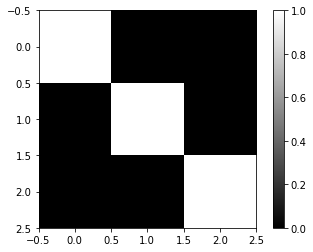

In [114]:
# Perfect classifier's confusion matrix
conf_mat = confusion_matrix([1, 1, 2, 2, 3, 3], [1, 1, 2, 2, 3, 3])
print(conf_mat)
plt.imshow(conf_mat/conf_mat.max(), cmap='gray')
plt.colorbar()

[[2. 0. 0.]
 [0. 1. 1.]
 [1. 1. 0.]]


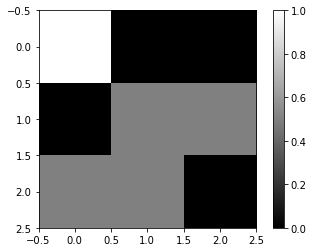

In [115]:
# A not-so-perfect classifier's confusion matrix
conf_mat = confusion_matrix([1, 1, 2, 2, 3, 3], [1, 1, 2, 3, 1, 2])
print(conf_mat)
plt.imshow(conf_mat/conf_mat.max(), cmap='gray')
plt.colorbar()

### `grid_plot`

The function `grid_plot` takes as input:

- `classifier` - a classifier such as `NeighborhoodClassifier`
- `train` - a training set
- `test` - a test set
- `n_points` - the width/height of the grid on which to visualize the decision boundary (n, n)

Depending on the speed of your computer, calculating of predictions on the grid can be slow. We recommend doing the first tests with a small grid (say, 25 by 25). You could then augment the size of the grid to 50x50 or even 100x100 to obtain better looking visualizations.

In [116]:
# function plot
def grid_plot(classifier, train, test, n_points=50):

    train_test = np.vstack((train, test))
    (min_x1, max_x1) = (min(train_test[:, 0]) - .25, max(train_test[:, 0]) + .25)
    (min_x2, max_x2) = (min(train_test[:, 1]) - .25, max(train_test[:, 1]) + .25)

    x_grid = np.linspace(min_x1, max_x1, num=n_points)
    y_grid = np.linspace(min_x2, max_x2, num=n_points)

    # calculates the cartesian product between two lists and stores the result in an array
    the_grid = np.array(combine(x_grid, y_grid))

    predicted_classes = classifier.compute_predictions(the_grid)

    # The grid
    plt.pcolormesh(x_grid, y_grid, predicted_classes.reshape((n_points, n_points)).T, cmap=plt.cm.cool, alpha=.1)
    # Training data points
    plt.scatter(train[:, 0], train[:, 1], c=train[:,-1], cmap=plt.cm.cool, marker='o', s=70, label='train')
    # Test data points
    plt.scatter(test[:, 0], test[:, 1], c=test[:,-1], cmap=plt.cm.cool, marker='x', s=70, label='test')

    plt.legend()
    plt.show()
    
# http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
    for example: combine((1,2),(3,4)) returns
    [[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin, listout, comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb = comb + [item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:], listout, newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout = []                        # listout initialization
    rloop(seqin, listout, [])           # start recursive process
    return listout

## NeighborhoodClassifier class

The class `NeighborhoodClassifier` takes as parameters:

- `parzen` - if set to True, the classifier is a Parzen windows one ; otherwise, the classifier is KNN
- `dist_func` - a function to calculate the distance between points
- `k` - the number of neighbors to visit (For knn only)
- `radius` - the radius that defines the Parzen Windows (For Parzen windows only)

The method `train` is actually really only storing the dataset. All of the work is done at prediction time for `NeighborhoodClassifier`  models.

The method `compute_predictions()` takes as input the unlabeled test set in matrix form and returns the array containing the predictions. The returned array `classes_pred` is one-dimensional and has `n_examples` elements.

You will need, for each test set example, to:

 - **Calculate distances** for every point of the training set (using dist_func)
 - Look through the distances to **find the $k$ nearest neighbors** (or **find the training points belonging to the ball of the wanted radius** in the case of a Parzen windows classifier) of the current test example
 - **Calculate the number of neighbors per class** and save them in `counts`
 - **Evaluate the predicted class** from `counts` and save it in `classes_pred`
 

For Parzen classifiers, sometimes the test example is far from train examples, and the list of neighbors would then be empty. **One way to deal with such test examples is to double the radius until the list of neighbors contains at least one element.** Another way is to randomly select the label for such test examples.


In [117]:
class NeighborhoodClassifier:
    def __init__(self, parzen=False, dist_func=minkowski_mat, k=1, radius=0.4):
        self.parzen = parzen
        self.dist_func = dist_func
        self.k = k
        self.radius = radius

    # The train function for knn / Parzen windows is really only storing the dataset
    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        self.n_classes = len(np.unique(train_labels))

    # The prediction function takes as input test_data and returns an array containing the predicted classes. 
    def compute_predictions(self, test_data):
        # Initialization of the count matrix and the predicted classes array
        num_test = test_data.shape[0]
        counts = np.ones((num_test, self.n_classes))
        classes_pred = np.zeros(num_test)
        distance=[]
        # For each test datapoint
        for (i, ex) in enumerate(test_data):   
            distances=self.dist_func(ex,self.train_inputs)
            
            if self.parzen: 
                neighbours_idx=[]
                radius=self.radius
                while len(neighbours_idx)==0:
                    for j,d in enumerate(distances):
                        if d<self.radius:
                            neighbours_idx.append(j)
                    radius*=2                 
            else:
                neighbours_idx=np.argsort(distances)[:self.k]
                
            for idx in neighbours_idx:
                true_label=self.train_labels[idx]
                counts[i,int(true_label)-1]+=1
            
            classes_pred[i]=np.argmax(counts[i])+1
                
            
            # i is the row index
            # ex is the i'th row

            # Find the distances to each training set point using dist_func
            # ---> Write code here 
#             dist=minkowski_mat(ex,train_inputs,2)
#             # Go through the training set to find the neighbors of the current point (ex)
#             # You will distinguish between Parzen and KNN here
#             # ---> Write code here
#             index=[]
#             cls=[]
#             for i in range(0,3):
#                 index.append((np.argmin(dist)))
                
#                 dist[index[i]]=10
#             cls.append(train_labels[index])
# #             print(dist)
# #             print(index,cls)
                
#              # Calculate the number of neighbors belonging to each class and write them in counts[i,:]
#             # ---> Write code here
            
#             # From the counts matrix, define classes_pred[i] (don't forget that classes are labeled from 1 to n)
#             # ---> Write code here
#             print(cls)
#             classes_pred[i]=np.max(cls)
# #         print(classes_pred)
#         print(train_labels)
        return classes_pred

## Initialization and training of the classifiers


In [118]:
# Number of neighbors (k) for knn
k = 3
radius = 0.9
print("We will train ", k, "-NN and a Parzen classifier with radius ", radius, " on ", n_train, " training examples")

# Create the classifiers
knn = NeighborhoodClassifier(parzen=False, dist_func=minkowski_mat, k=k)
parzen = NeighborhoodClassifier(parzen=True, dist_func=minkowski_mat, radius=radius)

# We train the models
knn.train(train_inputs, train_labels)
parzen.train(train_inputs, train_labels)

# We get predictions
t1 = time.process_time()
classes_pred_knn = knn.compute_predictions(test_inputs)
t2 = time.process_time()
print('It took knn ', t2 - t1, ' seconds to get the predictions on ', test_inputs.shape[0],' test set examples')
t1 = time.process_time()
classes_pred_parzen = parzen.compute_predictions(test_inputs)
t2 = time.process_time()
print('It took Parzen ', t2 - t1, ' seconds to get the predictions on ', test_inputs.shape[0],' test set examples')

We will train  3 -NN and a Parzen classifier with radius  0.9  on  100  training examples
It took knn  0.0  seconds to get the predictions on  50  test set examples
It took Parzen  0.015625  seconds to get the predictions on  50  test set examples


In [119]:
classes_pred_knn

array([3., 2., 2., 2., 2., 1., 3., 3., 1., 2., 2., 1., 1., 2., 1., 1., 2.,
       1., 3., 1., 2., 3., 2., 3., 2., 3., 3., 1., 2., 3., 2., 3., 1., 1.,
       1., 1., 1., 2., 2., 3., 1., 3., 2., 1., 3., 2., 1., 3., 1., 3.])

## Confusion matrix and decision boundary

Here we define a function that given a model and a prediction array, prints the confusion matrix, which is very useful for analyzing which classes our classifier is having a hard time predicting. It also creates a graph displaying the training points as well as the test points and the decision boundary of our model. We try this function on the predictions made by both classifiers. We run this function on the two classifiers we trained in the previous section.

Before moving on to the next section, please make sure that your implementation works well by executing this code. Do not hesitate to ask questions if you have trouble interpreting the confusion matrix or the graph.

The confusion matrix is:
[[18.  0.  0.]
 [ 0. 12.  6.]
 [ 0.  5.  9.]]
The test error is  22.0 %


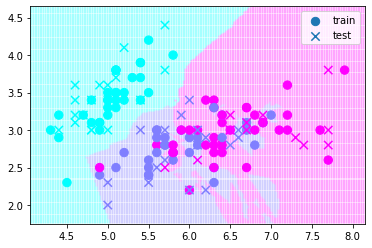

It took  2.7  seconds to calculate the predictions on 40000  points of the grid
We will save the plot into grid__k=3_c1=0_c2=1.png
The confusion matrix is:
[[18.  0.  0.]
 [ 1. 12.  5.]
 [ 0.  2. 12.]]
The test error is  16.0 %


In [ ]:
def show_results(model, classes_pred):
    # Confusion Matrix
    conf_mat = confusion_matrix(test_labels, classes_pred)
    print('The confusion matrix is:')
    print(conf_mat)

    # Test error
    total_num = np.sum(conf_mat)
    num_correct = np.sum(np.diag(conf_mat))
    print("The test error is ", round(100 * (1.0 - (float(num_correct) / float(total_num))), 2), "%")

    # The grid size will be = grid_size x grid_size
    grid_size = 200

    if len(train_cols) == 2:
        # Decision boundary
        t1 = time.process_time()
        grid_plot(model, train_set, test_set, n_points=grid_size)
        t2 = time.process_time()
        print('It took ', round(t2 - t1, 2), ' seconds to calculate the predictions on', grid_size * grid_size,
              ' points of the grid')
        if model.parzen:
            filename = 'grid_' + '_radius=' + str(model.radius) + '_c1=' + str(train_cols[0]) + '_c2=' + str(
                train_cols[1]) + '.png'
        else:
            filename = 'grid_' + '_k=' + str(model.k) + '_c1=' + str(train_cols[0]) + '_c2=' + str(
                train_cols[1]) + '.png'
        print('We will save the plot into {}'.format(filename))
        plt.savefig(filename, format='png')
    else:
        print('Too many dimensions (', len(train_cols), ') to print the decision boundary')

show_results(knn, classes_pred_knn)
show_results(parzen, classes_pred_parzen)

## Trying different values of k for k-NN


Now that your implementation is correct, we can train different k-NN classifiers, and choose the best value for $k$. The way we are going to do this is to plot the test error as a function of $k$, and use the plot to pick the best value. However, this method has a shortcoming (**what is it?**), and one way to mitigate it is to use a validation set. You will have the opportunity in the next section to try using it.

You will need to fill in the following `get_test_error`.

This function takes as input `k`, and returns the test error of a k-NN classifier. You will need to instantiate the classifier, train it, compute the predictions on the `test_inputs`, compute the confusion matrix, and use it to get the test error.

In [ ]:
def get_test_error(k):
    # ---> Write code here 
    return round(100 * (1.0 - (float(num_correct) / float(total_num))), 2)

Using the function `get_test_error`, we will plot the test error against the values of $k$ from 1 to 100 (remember that there are 100 training examples).

In [ ]:
plt.plot(range(1, 100), [get_test_error(k) for k in range(1, 100)], label='test error')
plt.legend()
plt.xlabel('number of neighbors')
plt.show()

## Experimenting

Now that everything is working properly, it is time to play with the model in order to better understand the different parameters. Work directly with the code above to run these tests.

- Try different values for the radius of the Parzen windows classifier, and plot a similar figure than the one you made in the previous section. Which of the two algorithms is more robust to its hyperparameter on this dataset?

- Vary the size of `train_set` and `test_set` and observe the impact that it has on the test error and the decision boundary

- Divide the training set into 3 parts: `train_set`, `valid_set` and `test_set` (of size 100, 25 and 25, for example). Train $k$-nn on `train_set`, then choose the optimal $k$ using the `valid_set` and finally obtain an estimate of the generalization error of your model by testing on `test_set`. This time, use all 4 features of the dataset. What do you think the validation set is used for?
  - Is there a difference between the validation error and the test error for the optimal $k$ found using the validation set? Should there be?

- Uncomment the line `random.seed(3395)` and run your code multiple times to get statistics on the validation and test errors. You can write a `for` loop to execute the same piece of code multiple times; 10 times should be enough. Calculate the mean and standard deviation for each error.

Do not hesitate to validate your answers by asking questions.